# k-Nearest Neighbor (kNN) exercise

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
# set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'data/cifar-10-batches-py'

#from cs231n.cifar import load_CIFAR10
#X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

from cs231n.cifar import unpickle
X_train, y_train = unpickle(cifar10_dir + '/data_batch_1')
X_test, y_test = unpickle(cifar10_dir + '/test_batch')

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (10000, 3072)
Training labels shape:  (10000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


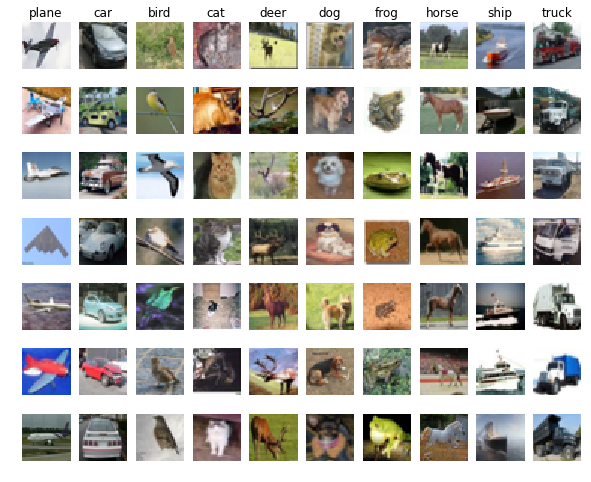

In [17]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
sampler_per_class = 7
for y, cls in enumerate(classes):
    indices = np.flatnonzero(y_train == y)
    indices = np.random.choice(indices, sampler_per_class, replace=False)
    for i, idx in enumerate(indices):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sampler_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(3, 32, 32).transpose(1, 2, 0).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [3]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


In [4]:
from cs231n.nn import KNearestNeighbor

# Create a kNN classifier instance
# Remember that training a kNN classifier is a noop:
# the classifier simply remembers the data and does no further processing.
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [4]:
dists = classifier.compute_norm1_distances_two_loops(X_test)
print dists.shape

(500, 5000)


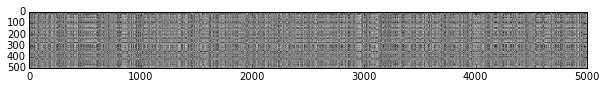

In [21]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')

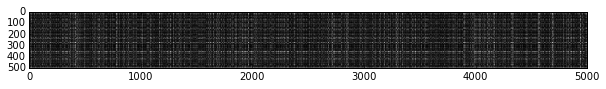

In [6]:
dists = classifier.compute_norm2_distances_no_loop(X_test)
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')

Inline Question \#1: Notice the structured patterns in the distance matrix.

-    What is the cause behind the distinctly visible rows?
-    What causes the columns?

Your Answer:

-    Each test image will have variant L2 distance to the training images
-    Each training image have distinct L2 distance to the test images



In [7]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 103 / 500 correct => accuracy: 0.206000


In [7]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


In [17]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  dists = f(*args)
  toc = time.time()
  return toc - tic, dists

X_test10 = X_test[0:10, :]

In [18]:
# you should see significantly faster performance with the fully vectorized implementation
two_loop_time, dists_two = time_function(classifier.compute_norm1_distances_two_loops, X_test10)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time, dists_one = time_function(classifier.compute_norm1_distances_one_loop, X_test10)
print 'One loop version took %f seconds' % one_loop_time

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
print 'Difference of one loop was: %f' % (np.linalg.norm(dists_two - dists_one, ord='fro'))

Two loop version took 3.346043 seconds
One loop version took 4.737856 seconds
Difference of one loop was: 0.000000


In [19]:
# you should see significantly faster performance with the fully vectorized implementation
two_loop_time, dists_two = time_function(classifier.compute_norm2_distances_two_loops, X_test10)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time, dists_one = time_function(classifier.compute_norm2_distances_one_loop, X_test10)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time, dists_no = time_function(classifier.compute_norm2_distances_no_loop, X_test10)
print 'No loop version took %f seconds' % no_loop_time

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
print 'Difference of two/one loop was: %f' % (np.linalg.norm(dists_two - dists_one, ord='fro'))
print 'Difference of two/no loop was: %f' % (np.linalg.norm(dists_two - dists_no, ord='fro'))
print 'Difference of one/no loop was: %f' % (np.linalg.norm(dists_one - dists_no, ord='fro'))

Two loop version took 3.357393 seconds
One loop version took 0.594343 seconds
No loop version took 0.672184 seconds
Difference of two/one loop was: 0.000000
Difference of two/no loop was: 0.000000
Difference of one/no loop was: 0.000000


## Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.


In [8]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
idxes = range(num_training)
idx_folds = np.array_split(idxes, num_folds)
for idx in idx_folds:
#     mask = np.ones(num_training, dtype=bool)
#     mask[idx] = False
#     X_train_folds.append( (X_train[mask], X_train[~mask]) )
#     y_train_folds.append( (y_train[mask], y_train[~mask]) )
    X_train_folds.append( X_train[idx] )
    y_train_folds.append( y_train[idx] )
    
# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
import sys
classifier = KNearestNeighbor()
Verbose = False
for k in k_choices:
    if Verbose: print "processing k=%f" % k
    else: sys.stdout.write('.')
    k_to_accuracies[k] = list()
    for num in xrange(num_folds):
        if Verbose: print "processing fold#%i/%i" % (num, num_folds)
        
        X_cv_train = np.vstack( [ X_train_folds[x] for x in xrange(num_folds) if x != num ])
        y_cv_train = np.hstack( [ y_train_folds[x].T for x in xrange(num_folds) if x != num ])
        
        X_cv_test = X_train_folds[num]
        y_cv_test = y_train_folds[num]

        # train k-nearest neighbor classifier
        classifier.train(X_cv_train, y_cv_train)
        
        # calculate trained matrix        
        y_cv_test_pred = classifier.predict(X_cv_test, k=k)
        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_cv_test_pred == y_cv_test)
        k_to_accuracies[k].append( float(num_correct) / y_cv_test.shape[0] )

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

..........k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k 

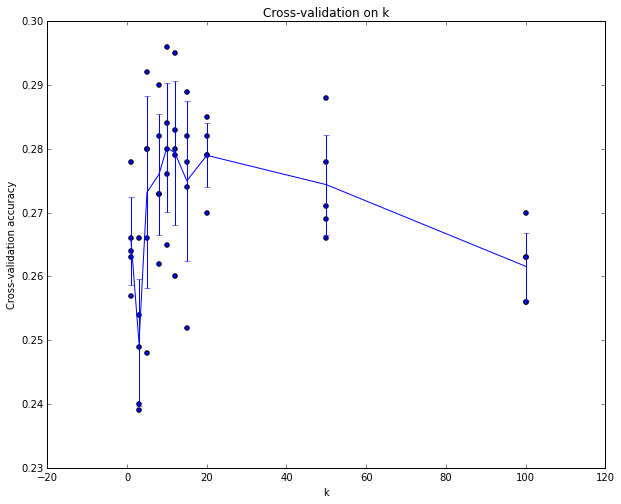

In [9]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [10]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.
best_k = 6

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 141 / 500 correct => accuracy: 0.282000
